# 3 levels opsine model

This script implements a simple 2 level model.
The model is described in the following figure:

<img src="imgs/3levels_model.svg" width="30%">

The transition OD, from the Open to the Deactivated state, is considered to be influenced by light.

No transition is admitted from C to O or from O to C. This choice simplyfies the model and it is justified by the very long time required for current recovery (experimentally ~30s).

In [1]:
from matplotlib.pyplot import plot, axis, subplot, title, figure

from numpy.linalg import norm
from numpy import array, max, zeros, linspace, copy
from scipy.integrate import odeint

import sys
sys.path.append('../scripts')
from opsine_model_utils.utils import Pulse
from opsine_model_utils.models import ode_model_generic
from opsine_model_utils.analytical_solver import *
from marco_tools.parseDatafile import *

%matplotlib inline 

Load experimental data (Rossella).
Normalize the data to the absolute value (of all data)

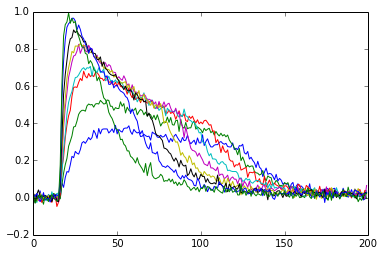

In [2]:
# Experimental data
folder = '../experimental'
filename = '/cell_100_ChR2.txt'

data = array(parseDatafile( folder + filename,'\t', cast='float' ))
#datalength = len(data[n_data])
#t = [it*dt for it in range(0,datalength)]

N = min(data[-1])

for i,d in enumerate(data):
    d = d/N
    plot(d[1000:-2000:10],'-');
    data[i] = d
#axis([90,300,0,1.2])



declare some experimental constants

In [3]:
dt = 0.1 #acquisition time [ms]

#power (I don't know in what unit)
powervalues = array([
0.0836012861736334,
0.0498392282958199,
0.0249196141479099,
0.0160771704180064,
0.0128617363344051,
0.00803858520900321,
0.00643086816720257,
0.00321543408360128,
0.00160771704180064,
])

powervalues = powervalues[::-1] # invert the order

# the pulse end time varies for each experiment
pulse_end_times = array( [225,215,205,195,185,175,165,155,135] )

define ceofficient matrix

In [4]:
lightpower = powervalues[0]

# CONSTANTS DEFINING THE STATES
C = 0   # Closed state
O = 1   # Opens state
D = 2   # Desensitized state

# TRANSITION RATES
K_off = zeros([3,3]) # transition coefficient MATRIX when light is OFF
K_on =  zeros([3,3]) # transition coefficient MATRIX when light is ON

tau = 25 #17.9 # usually called "tauoff" [ms] Exp Physiol. 2011 Jan; 96(1): 19–25. 
k = 1.0/tau

alpha = 450# fit parameter
beta = 1/0.00160771704180064# fit parameter

K_off[O,C] = k
K_on[O,C] = K_off[O,C] # this transition does not depend on light

K_off[C,O] = 0
K_on[C,O] = k*lightpower*alpha

K_off[O,D] = k/150*40
K_on[O,D] = k/(150)*(lightpower*beta+40)

K_off[D,O] = k/30
K_on[D,O] = K_off[D,O] # k/30

lets's fit with odeint and with the solver i have wrote. (unfortunately odeint does not work always well)

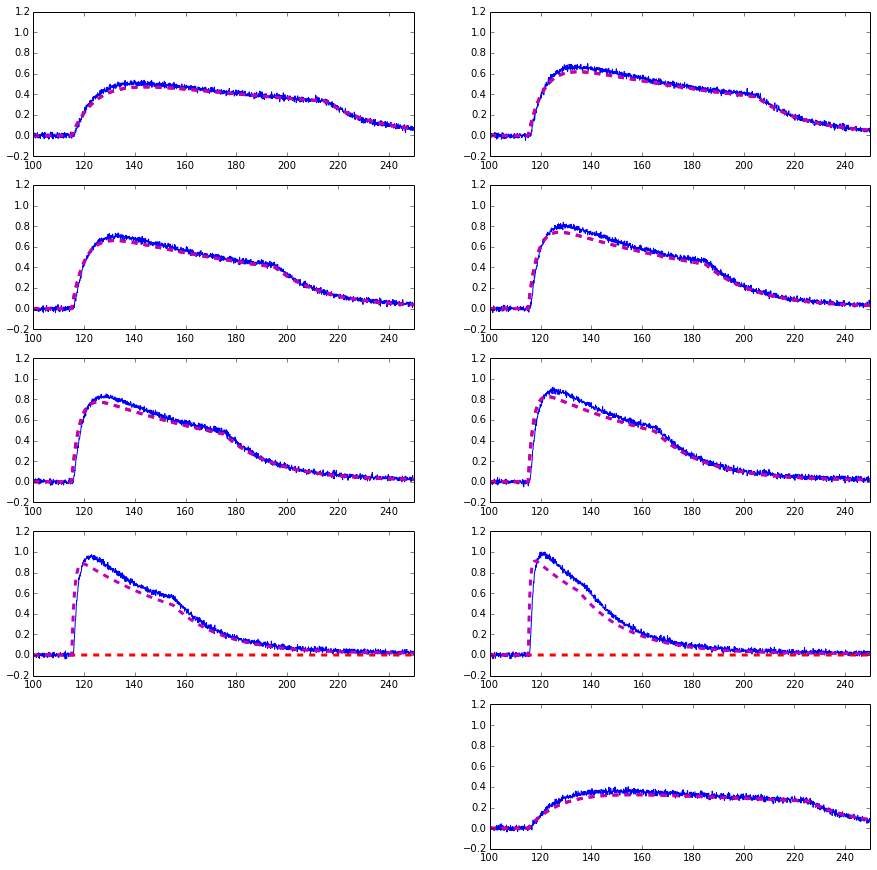

In [5]:
figure(figsize=(15,15))

initial_condition = [1,0,0]

for n_data,d in enumerate(data):
    lightpower = powervalues[n_data]       # set the light dependent parameters
    K_on[C,O] = k*lightpower*alpha
    K_on[O,D] = k/(150)*(lightpower*beta+40)

    pulse_start = 115
    pulse_duration = pulse_end_times[n_data]-pulse_start
    pulse = Pulse(115,pulse_duration,500)

    t = [it*dt for it in range(0,len(data[n_data]))]
    v = odeint(ode_model_generic,initial_condition,t,(K_off,K_on,pulse))
    s = PulsedSolver(K_on,K_off,initial_condition,t,pulse)
    
    subplot(5,2,n_data)
    plot(t,d);
    plot(t,v[:,1],'r--',linewidth='3');
    plot(t,s.solution()[1],'m--',linewidth='3');
    axis([100,250,-0.2,1.2]);


if you wander that the model for odeint might be wrong, I explicitly write it

In [ ]:
def three_states_with_light(n,t):
    # just renameing for better convenience
    Nc = n[0]
    No = n[1]
    Nd = n[2]
    
    #if t < pulse_start:
    #    K = zeros([3,3])
    
    if t >= pulse_start and t < pulse_end:
        K = K_on
    else:
        K = K_off

    
    return [
            -K[C,O]*Nc -K[C,D]*Nc +K[D,C]*Nd +K[O,C]*No, # = Nc'
            -K[O,D]*No -K[O,C]*No +K[C,O]*Nc +K[D,O]*Nd, # = No'
            -K[D,C]*Nd -K[D,O]*Nd +K[O,D]*No +K[C,D]*Nc # =Nd'
            ]

but the problem is still there

In [ ]:
figure(figsize=(15,15))

for n_data,d in enumerate(data):
    lightpower = powervalues[n_data]       # set the light dependent parameters
    K_on[C,O] = k*lightpower*alpha
    K_on[O,D] = k/(150)*(lightpower*beta+40)

    pulse_start = 115
    pulse_end = pulse_end_times[n_data]
    pulse_duration = pulse_end-pulse_start
    pulse = Pulse(115,pulse_duration,500)

    t = [it*dt for it in range(0,len(data[n_data]))]
    v = odeint(three_states_with_light,initial_condition,t)             # changed the function here
    
    subplot(5,2,n_data)
    plot(t,d);
    plot(t,v[:,1],'r--',linewidth='3');
    axis([100,250,-0.2,1.2]);


one can tell odeint a set of point where the integration must be more careful with the optional tcrit parameter ( tcrit=[pulse_start+1] )

or reduce the max integration step to a value below the shortest pulse duration, with the optional parameter hmax

In [ ]:
figure(figsize=(15,15))

for n_data,d in enumerate(data):
    lightpower = powervalues[n_data]       # set the light dependent parameters
    K_on[C,O] = k*lightpower*alpha
    K_on[O,D] = k/(150)*(lightpower*beta+40)

    
    dt = 0.1 #acquisition time [ms]
    pulse_start = 115
    pulse_end = pulse_end_times[n_data]
    pulse_duration = pulse_end - pulse_start
    
    t = linspace(0,len(data[n_data])*dt,len(data[n_data]))
    #t = [it*dt for it in range(0,len(data[n_data]))]
    v = odeint(three_states_with_light,initial_condition,t,hmax=10)
    # changed the function here
    
    subplot(5,2,n_data)
    plot(t,d);
    plot(t,v[:,1],'r--',linewidth='3');
    axis([100,250,-0.2,1.2]);